# Estimate Penetration From Bologna Data

In [ ]:
from collections import defaultdict
from datetime import datetime
import os
import polars as pl
import pandas as pd
import geopandas as gpd
from GeographyFunctions import FilterGeoDataFrameWithBoundingBox
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import numpy as np
from EstimatePenetration import *
from OpenData import *


2022-01-31
shape: (5, 4)
┌──────────────┬──────────┬─────────────┬───────────────────┐
│ total_fluxes ┆ id_local ┆ 00:00-01:00 ┆ penetration_total │
│ ---          ┆ ---      ┆ ---         ┆ ---               │
│ i64          ┆ i64      ┆ i64         ┆ f64               │
╞══════════════╪══════════╪═════════════╪═══════════════════╡
│ 6            ┆ 505      ┆ 75          ┆ 0.08              │
│ 6            ┆ 505      ┆ 59          ┆ 0.101695          │
│ 6            ┆ 505      ┆ 45          ┆ 0.133333          │
│ 6            ┆ 505      ┆ 74          ┆ 0.081081          │
│ 6            ┆ 505      ┆ 26          ┆ 0.230769          │
└──────────────┴──────────┴─────────────┴───────────────────┘
shape: (5, 4)
┌──────────────┬──────────┬─────────────┬───────────────────┐
│ total_fluxes ┆ id_local ┆ 01:00-02:00 ┆ penetration_total │
│ ---          ┆ ---      ┆ ---         ┆ ---               │
│ i64          ┆ i64      ┆ i64         ┆ f64               │
╞══════════════╪══════════╪════

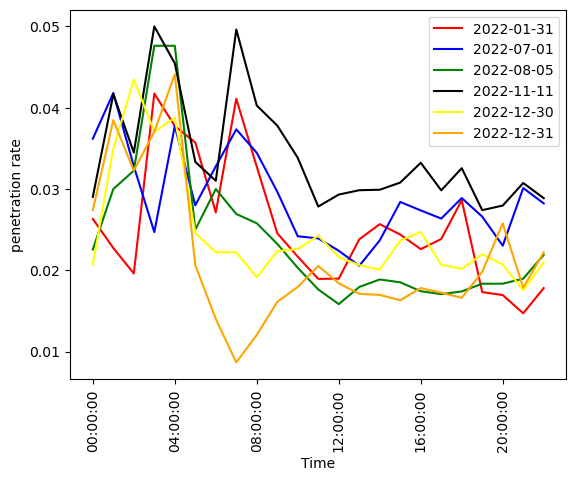

In [ ]:
# Names Project
name_folder_related_to_bbox = "bologna_mdt_center"

# Directories: Dependent on the bbox
plot_dir = os.path.join(os.environ["WORKSPACE"],f"city-pro","output",name_folder_related_to_bbox,"plots")
DirOpenDataBologna = os.path.join(os.environ["WORKSPACE"],"city-pro","bologna_mdt_detailed","carto")                            # NOTE: 


# Days - Days related variables
Days = ["2022-01-31","2022-07-01","2022-08-05","2022-11-11","2022-12-30","2022-12-31","2023-01-01","2023-03-18"] 



FilePro = os.path.join(DirOpenDataBologna, "bologna_mdt_cleaned.pro")

# Open Data
GdfTrafficOpenData2022,Column2ConsiderGdfTrafficOpenData,TimeRanges = OpenDataFrameSpireAndTransformGeoData(DirOpenDataBologna,Days,StrFile = "rilevazione-flusso-veicoli-tramite-spire-anno-2022.csv")
# GdfTrafficOpenData2023,_,_ = OpenDataFrameSpireAndTransformGeoData(DirOpenDataBologna,Days,StrFile = "accuratezza-spire-anno-2023.csv")
output_dir = os.path.join(os.environ["WORKSPACE"],"city-pro","output")
Day = "2022-01-31"
GdfRoads = gpd.read_file(os.path.join(output_dir,f"{name_folder_related_to_bbox}/plots/{Day}/GeoJson_{Day}.geojson"))
GdfRoads.set_crs(epsg=4326, inplace=True)
lat_min = 44.487106
lat_max = 44.528131
lon_min = 11.293156
lon_max = 11.378143
Bbox = (lon_min, lon_max, lat_min, lat_max)
GdfRoads = FilterGeoDataFrameWithBoundingBox(GdfRoads,Bbox)
fig,ax = plt.subplots()
Colors = ["red","blue","green","black","yellow","orange","purple","pink"]
Day2Color = dict(zip(Days,Colors))

for Day in Days:
    print(Day)
    TimeRange2Time = GetTimeRanges(TimeRanges,Day)
    TimedFluxes = pl.read_csv(os.path.join(os.environ["WORKSPACE"],"city-pro","output",name_folder_related_to_bbox,f"bologna_mdt_{Day}_{Day}_timed_fluxes.csv"),separator=';')
    # Ensure both GeoDataFrames use the same CRS
    # Perform a spatial join to associate points with the nearest roads
    if "2023" in Day:
        break
    else:
        GdfTrafficOpenData = GdfTrafficOpenData2022.to_crs(epsg=3857)
    GdfRoads = GdfRoads.to_crs(epsg=3857)    
    GdfJoin = gpd.sjoin_nearest(GdfTrafficOpenData, GdfRoads, how='left', distance_col='distance')
    GdfJoin = GdfJoin.loc[GdfJoin["distance"]<2]
    GdfJoin.set_crs(epsg=4326, inplace=True,allow_override=True)
    GdfJoin = DiscardColumnsSpeedGdfRoads(GdfJoin)
    PolyLid2VectorFluxes = {"average_penetration_tot": [], "average_penetration_FT": [], "average_penetration_TF": []}
    TimeHours = [Time.split(" ")[1] for Time in TimeRange2Time.values()]
    for TimeRange in TimeRange2Time.keys():
        Time = TimeRange2Time[TimeRange]
        FluxesPolysAtTime = TimedFluxes.filter(pl.col("time") == Time)
        DfJoinAtTime = pl.DataFrame(GdfJoin[[TimeRange, "poly_lid"]])
        DfJoinAtTime = DfJoinAtTime.filter(pl.col(TimeRange).is_not_null(),
                            pl.col(TimeRange).is_not_nan(),
                            pl.col(TimeRange) > 0)
        DfJoinAtTime = DfJoinAtTime.with_columns(pl.col("poly_lid").cast(pl.Int64))
        FluxesPolysAtTime = FluxesPolysAtTime.with_columns(pl.col("id").cast(pl.Int64))
        FluxesPolysAtTime = FluxesPolysAtTime.join(DfJoinAtTime,left_on="id",right_on="poly_lid")
        
        FluxesPolysAtTime = FluxesPolysAtTime.with_columns((pl.col("total_fluxes")/pl.col(TimeRange)).alias("penetration_total"),
                                                           (pl.col("n_traj_FT")/pl.col(TimeRange)).alias("penetration_FT"),
                                                           (pl.col("n_traj_TF")/pl.col(TimeRange)).alias("penetration_TF")
                                                           )
        FluxesPolysAtTime = FluxesPolysAtTime.filter(pl.col("penetration_total").is_not_null(),
                                                     pl.col("penetration_FT").is_not_null(),
                                                    pl.col("penetration_TF").is_not_null(),
                                                    pl.col("penetration_total").is_not_nan(),
                                                    pl.col("penetration_FT").is_not_nan(),
                                                    pl.col("penetration_TF").is_not_nan(),
                                                    pl.col("penetration_total") > 0,
                                                    pl.col("id")!=18952)
        PenetrationTotal = np.nanmedian(FluxesPolysAtTime["penetration_total"].to_numpy())
        PenetrationFT = np.nanmedian(FluxesPolysAtTime["penetration_FT"].to_numpy())
        PenetrationTF = np.nanmedian(FluxesPolysAtTime["penetration_TF"].to_numpy())
        PolyLid2VectorFluxes["average_penetration_tot"].append(PenetrationTotal) 
        PolyLid2VectorFluxes["average_penetration_FT"].append(PenetrationFT)
        PolyLid2VectorFluxes["average_penetration_TF"].append(PenetrationTF) 
#    ax.plot(TimeHours,PolyLid2VectorFluxes["average_penetration_tot"],label=Day,color=Day2Color[Day])
    ax.plot(TimeHours,PolyLid2VectorFluxes["average_penetration_FT"],label=Day,color=Day2Color[Day])
#    ax.plot(TimeHours,PolyLid2VectorFluxes["average_penetration_TF"],label=Day,color=Day2Color[Day])
    ax.legend()
    ax.set_xticks(range(len(TimeHours))[::4])  # Set the ticks to correspond to the labels
    ax.set_xticklabels(TimeHours[::4], rotation=90)  # Set the labels with rotation    ax.set_title("Time Percorrence Distribution")
    ax.set_xlabel("Time")
    ax.set_ylabel("penetration rate")
plt.savefig(os.path.join(os.environ["WORKSPACE"],"city-pro","output",name_folder_related_to_bbox,"penetration.png"))
plt.show()

len GdfTrafficOpenData 5051
len GdfTrafficOpenDataFilter 3936


/home/aamad/miniconda3/envs/geostuff_new/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


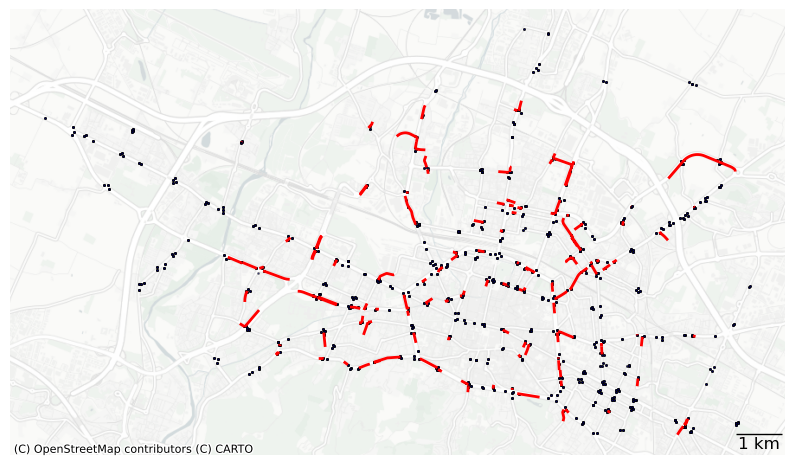

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from shapely.geometry import box
# Filter
lon_min = 11.254601
lon_max = 11.396050
lat_min = 44.479459
lat_max = 44.536751

b_box =  box(lon_min, lat_min, lon_max, lat_max)
GdfTrafficOpenData.to_crs(epsg=4326, inplace=True)
print("len GdfTrafficOpenData",len(GdfTrafficOpenData))
GdfTrafficOpenDataFilter = GdfTrafficOpenData.loc[GdfTrafficOpenData["geometry"].within(b_box)]
print("len GdfTrafficOpenDataFilter",len(GdfTrafficOpenDataFilter))
# Assuming GdfTrafficOpenData and GdfRoads are already loaded

# Filter and prepare the GdfRoads GeoDataFrame
GdfRoads["AtTimet"] = GdfRoads["poly_lid"].apply(lambda x: x in FluxesPolysAtTime["id"].to_list())
GdfRoads.to_crs(epsg=3857, inplace=True)
Columns2Accept = [col for col in GdfRoads.columns if 'Speed' not in col]
GdfRoads = GdfRoads[Columns2Accept]

# Convert GdfTrafficOpenData to EPSG:3857
GdfTrafficOpenDataFilter.to_crs(epsg=3857, inplace=True)
# Define the extent to the area of interest

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GdfTrafficOpenData as points
GdfTrafficOpenDataFilter.plot(ax=ax, alpha=0.5, edgecolor='k', marker='o', markersize=1,color='blue')

# Plot the filtered GdfRoads in red
GdfRoads.loc[GdfRoads["AtTimet"]].plot(ax=ax, color="red",linewidth=2)
ax.axis('off')
# Add a black and white basemap
ctx.add_basemap(ax, crs=GdfRoads.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)

# Set the extent to the area of interest
#ax.set_xlim(ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, zoom=12)[1][0], ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, zoom=12)[1][2])
#ax.set_ylim(ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, zoom=12)[1][1], ctx.bounds2img(lon_min, lat_min, lon_max, lat_max, zoom=12)[1][3])

# Add a scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax.transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
plt.savefig(os.path.join(os.environ["WORKSPACE"],f"city-pro","output",name_folder_related_to_bbox,"plots","map_coils_estimation_penetration.png"),bbox_inches='tight',dpi = 200)
plt.show()

(array([1.9151e+04, 3.5390e+03, 1.2280e+03, 3.9600e+02, 1.2900e+02,
        5.1000e+01, 2.1000e+01, 1.0000e+01, 6.0000e+00, 3.0000e+00]),
 array([  0. ,  12.3,  24.6,  36.9,  49.2,  61.5,  73.8,  86.1,  98.4,
        110.7, 123. ]),
 <BarContainer object of 10 artists>)

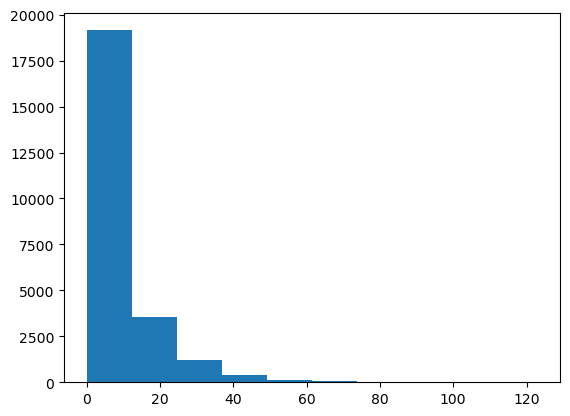

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv("/home/aamad/codice/city-pro/output/bologna_mdt_center/bologna_mdt_2022-07-01_2022-07-01_cut_traj.csv",sep=';')
plt.hist(df["size_traj"]) 

# Plot multiple classes

In [29]:
import geopandas as gpd
GdfClassesTraffic = gpd.read_file("/home/aamad/codice/city-pro/output/bologna_mdt_center/BolognaMDTClassInfo.geojson")

In [30]:
lat_min = 44.487106
lat_max = 44.528131
lon_min = 11.293156
lon_max = 11.378143
Bbox = (lon_min, lon_max, lat_min, lat_max)
GdfClassesTraffic = FilterGeoDataFrameWithBoundingBox(GdfClassesTraffic,Bbox)


# Plot Highways problem

In [ ]:
from collections import Counter
lids2focus = {33280:"autostrada sole (sud) dir. sud",
              77096:"autostrada sole (sud) dir. nord",
              2708:"autostrada sole (nord) dir. sud",
              49350:"autostrada bologna padova dir. sud",
              39431:"autostrada bologna padova dir. nord",
              45240:"autostrada adriatica dir. sud",
              2603:"autostrada adriatica dir. nord",
              31386:"tangenziale sud verso casalecchio",
              31717:"tangenziale sud verso san lazzaro"}
lid2color = {33280:"red",
              77096:"blue",
              2708:"green",
              49350:"black",
              39431:"yellow",
              45240:"orange",
              2603:"purple",
              31386:"pink",
              31717:"brown"}
list_lids = list(sorted(lids2focus.keys()))
for StrDate in Days:
    df_paths = pl.read_csv(f"/home/aamad/codice/city-pro/output/bologna_mdt_center/bologna_mdt_{StrDate}_{StrDate}_paths_on_road.csv",separator=';')
    df_fluxes = pl.read_csv(f"/home/aamad/codice/city-pro/output/bologna_mdt_center/bologna_mdt_{StrDate}_{StrDate}_timed_fluxes.csv",separator=';')
    fcm = pl.read_csv(f"/home/aamad/codice/city-pro/output/bologna_mdt_center/bologna_mdt_{StrDate}_{StrDate}_fcm.csv")
    df_paths = df_paths.filter(pl.col("poly_id").is_in(lids2focus.keys()))
    df_fluxes = df_fluxes.filter(pl.col("id_local").is_in(list(lids2focus.keys())))
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    # Plot the fluxes in time
    for road in list_lids:
        df_fluxes_road = df_fluxes.filter(pl.col("id_local") == road)
        df_fluxes_road = df_fluxes_road.sort("time")
        ax.plot(df_fluxes_road["time"],df_fluxes_road["total_fluxes"],label=lids2focus[road],color = lid2color[road])
    ax.set_xlabel("Time")
    ax.set_ylabel("Fluxes")
        
    ax.set_xticklabels(df_fluxes_road["time"], rotation=90)
    ax.legend()
    plt.show()
    plt.close(fig)
    # Show classes that appear in the roads
    # Show classes that appear in the roads with grouped bar chart
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))

    # Prepare data for grouped bar chart
    road_class_counts = {}
    all_classes = set()

    for road in list_lids:
        df_fluxes_road = df_fluxes.filter(pl.col("id_local") == road)
        users_with_on_point_in_road = df_paths.filter(pl.col("poly_id") == road)["user_id"].unique().to_numpy()
        fcm_user_in_road = fcm.filter(pl.col("id_act").is_in(users_with_on_point_in_road))
        count_user_in_class_per_road = Counter(fcm_user_in_road["class"])
        road_class_counts[road] = count_user_in_class_per_road
        all_classes.update(count_user_in_class_per_road.keys())

    # Sort classes for consistent ordering
    all_classes = sorted(all_classes)

    # Plot grouped bars
    bar_width = 0.1
    x = range(len(all_classes))
    for i, (road, class_counts) in enumerate(road_class_counts.items()):
        class_values = [class_counts.get(cls, 0) for cls in all_classes]
        ax.bar(
            [pos + i * bar_width for pos in x],
            class_values,
            bar_width,
            label=lids2focus[road],
            color=lid2color[road]
        )

    # Set x-axis labels and legend
    ax.set_xticks([pos + (len(road_class_counts) - 1) * bar_width / 2 for pos in x])
    ax.set_xticklabels(all_classes, rotation=45)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Count")
    ax.legend()
    plt.title("Distribution of Classes per Road")
    plt.tight_layout()

    plt.show()
    plt.close(fig)
    # Print distribution speed for different roads
    fig, ax = plt.subplots(2, 2, figsize=(15, 10),sharex=True,sharey=True,constrained_layout=True)
    class_idx2_plot_idx = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
    for class_ in [0,1,2,3]:
        for road in list_lids:
            users_with_on_point_in_road = df_paths.filter(pl.col("poly_id") == road)["user_id"].unique().to_numpy()
            fcm_user_in_road = fcm.filter(pl.col("id_act").is_in(users_with_on_point_in_road),
                                          pl.col("class") ==
                                          class_)
            speed_values = fcm_user_in_road["speed_kmh"].to_numpy()
            ax[class_idx2_plot_idx[class_]].hist(speed_values, bins=20, label=lids2focus[road], alpha=0.5, color=lid2color[road])
            ax[class_idx2_plot_idx[class_]].set_xlabel(r"$\langle v \rangle$ (km/h)")
            ax[class_idx2_plot_idx[class_]].set_ylabel("Count")
            ax[class_idx2_plot_idx[class_]].legend()
    plt.title("Distribution of Speed per Road")
    plt.tight_layout()
    plt.savefig(f"/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/speed_distribution_{StrDate}_highways.png")
    plt.show()
    plt.close(fig)

In [8]:
Days = ["2022-01-31","2022-07-01","2022-08-05","2022-11-11","2022-12-30","2022-12-31","2023-01-01","2023-03-18"]
columns = ["IntClassOrdered_"+ Day for Day in Days]
columns.append("geometry")
Classes = [0,1,2,3]
Uninon_column_names = ["Union_"+str(Class) for Class in Classes]
GdfSimplified = GdfClassesTraffic[columns]
GdfSimplified.head()
Union_column_name = "Union"
GdfClassesTraffic = GdfClassesTraffic.loc[GdfClassesTraffic["poly_lid"] != 45240]


In [ ]:
for Class in Classes:
    Union_column_name = Uninon_column_names[Class]
    roads_class = []
    for row,road_data in GdfSimplified.iterrows():
        is_in_class = False
        for Day in Days:
            if road_data["IntClassOrdered_"+Day] == Class:
                is_in_class = True
                roads_class.append(Class)
                break
        if not is_in_class:
            roads_class.append(-1)
    GdfSimplified[Union_column_name] = roads_class

# Union    
union_class_per_road = []
for row,road_data in GdfSimplified.iterrows():
    classes_per_road = []   
    for Union_column_name in Uninon_column_names:
        if road_data[Union_column_name] != -1:
            classes_per_road.append(road_data[Union_column_name])
        else:
            classes_per_road.append(-1)
    union_class_per_road.append(max(classes_per_road))
GdfSimplified["Union"] = union_class_per_road



# Temporary Plot Sub  

In [38]:
# Read the road classification data and create lists for each class
date = "2022-01-31"
file_path = f"/home/aamad/codice/city-pro/output/bologna_mdt_center/weights/bologna_mdt_{date}_{date}.fluxes.sub"

# Dictionary to store road IDs for each class
class_road_lists = {}

try:
    with open(file_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        line = line.strip()
        if line and not line.startswith("//"):  # Skip empty lines and comments
            parts = line.split("\t")
            if len(parts) >= 2:
                class_name = parts[0]  # e.g., "class_0_80", "class_1_80", etc.
                road_ids_str = parts[1:]  # The long string of road IDs
                # Convert string of road IDs to list of integers
                road_ids = [int(road_id) for road_id in road_ids_str if road_id.strip().isdigit()]
                
                class_road_lists[class_name] = road_ids
                print(f"{class_name}: {len(road_ids)} roads")
    
    # Display first 10 road IDs for each class as example
    for class_name, road_list in class_road_lists.items():
        print(f"\n{class_name} (first 10): {road_list[:10]}")
        
except FileNotFoundError:
    print(f"File not found: {file_path}")

# Extract just the numeric class indices (0, 1, 2, 3) and create clean lists
class_indices = {}
for class_name, road_list in class_road_lists.items():
    if "class_" in class_name and "_80" in class_name:
        # Extract class number (0, 1, 2, 3)
        class_num = int(class_name.split("_")[1])
        class_indices[class_num] = road_list


class_0_80: 5080 roads
class_1_80: 4986 roads
class_2_80: 2340 roads
class_3_80: 115 roads
tot_80: 1897 roads

class_0_80 (first 10): [390, 391, 392, 393, 394, 395, 417, 418, 419, 420]

class_1_80 (first 10): [390, 391, 392, 393, 394, 395, 417, 418, 419, 420]

class_2_80 (first 10): [448, 449, 450, 451, 452, 773, 798, 799, 859, 860]

class_3_80 (first 10): [773, 859, 2370, 2398, 2399, 2400, 2401, 2693, 2694, 2719]

tot_80 (first 10): [390, 391, 392, 393, 394, 395, 504, 505, 506, 507]


In [ ]:
# Read the road classification data for each class
date = "2022-01-31"
classes = [0, 1, 2, 3]

# Define custom colors for each class
custom_colors = {
    0: "blue",
    1: "orange", 
    2: "green",
    3: "red"
}

# Read road classification data and create plots for each class
date = "2022-01-31"
file_path = os.path.join(os.environ["WORKSPACE"],"city-pro","output","bologna_mdt_center","weights",f"bologna_mdt_{date}_{date}.fluxes.sub")

# Dictionary to store road IDs for each class
class_road_lists = {}

try:
    with open(file_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        line = line.strip()
        if line and not line.startswith("//"):  # Skip empty lines and comments
            parts = line.split("\t")
            if len(parts) >= 2:
                class_name = parts[0]  # e.g., "class_0_80", "class_1_80", etc.
                road_ids_str = parts[1:]  # The long string of road IDs
                # Convert string of road IDs to list of integers
                road_ids = [int(road_id) for road_id in road_ids_str if road_id.strip().isdigit()]
                
                class_road_lists[class_name] = road_ids
                print(f"{class_name}: {len(road_ids)} roads")
    
    # Display first 10 road IDs for each class as example
    for class_name, road_list in class_road_lists.items():
        print(f"\n{class_name} (first 10): {road_list[:10]}")
        
except FileNotFoundError:
    print(f"File not found: {file_path}")

# Extract just the numeric class indices (0, 1, 2, 3) and create clean lists
class_indices = {}
for class_name, road_list in class_road_lists.items():
    if "class_" in class_name and "_80" in class_name:
        # Extract class number (0, 1, 2, 3)
        class_num = int(class_name.split("_")[1])
        class_indices[class_num] = road_list
    
    # Filter GdfSimplified for roads in this class
    # Assuming 'poly_lid' is the column that matches road IDs - adjust if different
    road_id_column = 'poly_lid'  # Adjust this to match your actual column name
    
    # Create a copy of GdfSimplified for this class
    GdfClass = GdfClassesTraffic.copy()
    road_in_class = class_indices[class_num] if class_num in class_indices else []
    # Filter for roads in this class
    GdfClass = GdfClass.loc[GdfClass[road_id_column].isin(road_in_class)]
    
    if GdfClass.empty:
        print(f"No matching roads found in GeoDataFrame for class {class_}")
        continue
    
    # Ensure proper CRS
    GdfClass.to_crs(epsg=3857, inplace=True)
    
    # Create a figure for this class
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot roads for this class with class-specific color
    print(f"Plotting class {class_} with {len(GdfClass)} roads")
    GdfClass.plot(
        ax=ax, 
        color=custom_colors[class_num], 
        label=f"Class {class_num}", 
        alpha=1, 
        linewidth=2
    )
    
    # Get the bounds of the data in projected coordinates
    if not GdfClass.empty:
        minx, miny, maxx, maxy = GdfClass.total_bounds
        
        # Set limits in the projected coordinate system with some padding
        padding_x = (maxx - minx) * 0.05  # 5% padding
        padding_y = (maxy - miny) * 0.05  # 5% padding
        ax.set_xlim(minx - padding_x, maxx + padding_x)
        ax.set_ylim(miny - padding_y, maxy + padding_y)
    
    # Add a legend
    ax.legend(loc="upper right")
    
    # Remove coordinate ticks
    ax.axis('off')
    
    # Add a black and white basemap
    ctx.add_basemap(ax, crs=GdfClass.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)
    
    # Add a scale bar
    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(ax.transData,
                               1000, '1 km', 'lower right', 
                               pad=0.1,
                               color='black',
                               frameon=False,
                               size_vertical=1,
                               fontproperties=fontprops)
    ax.add_artist(scalebar)
    
    # Add title
#    plt.title(f"Road Network - Class {class_} ({date})", fontsize=14, pad=20)
    
    # Save the figure for this class
    plt.savefig(f"/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/road_class_{class_num}_{date}.png", 
                bbox_inches='tight', dpi=200)
    
    # Show the plot
    plt.show()
    
    # Close the figure to free memory
    plt.close(fig)

print("All class plots completed!")

# Mapping the Multi-Layer (Static)

In [ ]:
import contextily as ctx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

# Make sure GdfSimplified is filtered and projected correctly
GdfSimplified = GdfSimplified.loc[GdfSimplified["Union"] != -1]
GdfSimplified.to_crs(epsg=3857, inplace=True)

# Define custom colors for each category
custom_colors = {
    0: "blue",
    1: "orange",
    2: "green",
    3: "red"
}

# Create a figure with fixed dimensions
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GdfSimplified with custom colors
for category, color in custom_colors.items():
    print("plot class", category)
    GdfSimplified[GdfSimplified["Union"] == category].plot(
        ax=ax, color=color, label=category, alpha=1
    )

# Get the bounds of the data in projected coordinates
minx, miny, maxx, maxy = GdfSimplified.total_bounds

# Set limits in the projected coordinate system
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add some padding (10% on each side)
padding_x = 0# (maxx - minx) * 0.1
padding_y = 0#(maxy - miny) * 0.1
ax.set_xlim(minx - padding_x, maxx + padding_x)
ax.set_ylim(miny - padding_y, maxy + padding_y)

# Add a legend
ax.legend(loc="upper right")

# Remove coordinate ticks
ax.axis('off')

# Add a black and white basemap
ctx.add_basemap(ax, crs=GdfSimplified.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)

# Add a scale bar
fontprops = fm.FontProperties(size=12)
scalebar = AnchoredSizeBar(ax.transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=1,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# Save the figure
plt.savefig("/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/union_classes.png", 
            bbox_inches='tight', dpi=200)
plt.show()

## Multiple Days

In [ ]:
custom_colors = {
    0: "blue",
    1: "orange",
    2: "green",
    3: "red"
}

# Ensure all unique values in Union_column_name are mapped
#unique_values = GdfSimplified.loc[GdfSimplified.loc[GdfSimplified["Union"] != -1]][Union_column_name].unique()
#for value in unique_values:
#    if value not in custom_colors:
#        raise ValueError(f"Value '{value}' in Union_column_name is not mapped in custom_colors.")

# Plot the data

# Plot the GdfSimplified with custom colors
count_days = 0
for class_column_day in columns:
    fig, ax = plt.subplots(figsize=(10, 10))
    for category, color in custom_colors.items():
        print("plot class",category)
        GdfSimplified[GdfSimplified[class_column_day] == category].plot(
            ax=ax, color=color, label=category, alpha=1
        )

    # Set the aspect ratio to make the plot square
    #ax.set_aspect('equal', adjustable='datalim')

    # Add a legend
    ax.legend(loc="upper right")

    # Remove coordinate ticks
    ax.axis('off')

    # Add a black and white basemap
    ctx.add_basemap(ax, crs=GdfSimplified.crs.to_string(), source=ctx.providers.CartoDB.PositronNoLabels)

    # Add a scale bar
    fontprops = fm.FontProperties(size=12)
    scalebar = AnchoredSizeBar(ax.transData,
                            1000, '1 km', 'lower right', 
                            pad=0.1,
                            color='black',
                            frameon=False,
                            size_vertical=1,
                            fontproperties=fontprops)

    ax.add_artist(scalebar)
    
    plt.savefig(f"/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/union_classes_{Days[count_days]}.png",bbox_inches='tight',dpi = 200)
    plt.close()
    count_days+=1
    plt.show()

# Dynamic (Folium)

In [ ]:
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
import branca.colormap as cm

# First, convert GdfSimplified to EPSG:4326 (WGS84) for folium
GdfSimplified_4326 = GdfSimplified.copy()
GdfSimplified_4326 = GdfSimplified_4326.to_crs(epsg=4326)

# Get the center of the map
center = [GdfSimplified_4326.geometry.centroid.y.mean(), GdfSimplified_4326.geometry.centroid.x.mean()]

# Create a folium map
m = folium.Map(location=center, zoom_start=13, tiles='CartoDB positron')

# Define custom colors for the classes
custom_colors = {
    0: "blue",
    1: "orange",
    2: "green",
    3: "red"
}

# Custom function to style the GeoJSON
def style_function(feature):
    category = feature['properties']['Union']
    return {
        'fillColor': custom_colors.get(category, 'gray'),
        'color': custom_colors.get(category, 'gray'),
        'weight': 2,
        'fillOpacity': 0.7
    }

# Add hover functionality
def highlight_function(feature):
    return {
        'fillColor': custom_colors.get(feature['properties']['Union'], 'gray'),
        'color': 'black',
        'weight': 3,
        'fillOpacity': 0.9
    }

# Add a GeoJson layer for each category
for category, color in custom_colors.items():
    # Filter the GeoDataFrame for this category
    gdf_category = GdfSimplified_4326[GdfSimplified_4326['Union'] == category]
    
    if not gdf_category.empty:
        # Convert to GeoJSON
        geojson_data = gdf_category.to_json()
        
        # Add the GeoJSON to the map with popup information
        folium.GeoJson(
            geojson_data,
            name=f"Class {category}",
            style_function=lambda x, category=category: {
                'fillColor': custom_colors[category],
                'color': custom_colors[category],
                'weight': 2,
                'fillOpacity': 0.7
            },
            highlight_function=highlight_function,
            tooltip=folium.GeoJsonTooltip(
                fields=['Union'],
                aliases=['Class:'],
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
            )
        ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Add a scale bar
folium.plugins.MeasureControl(position='bottomleft', primary_length_unit='meters').add_to(m)

# Save the map
#m.save('/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/interactive_union_classes_folium.html')

# Display the map in the notebook
m

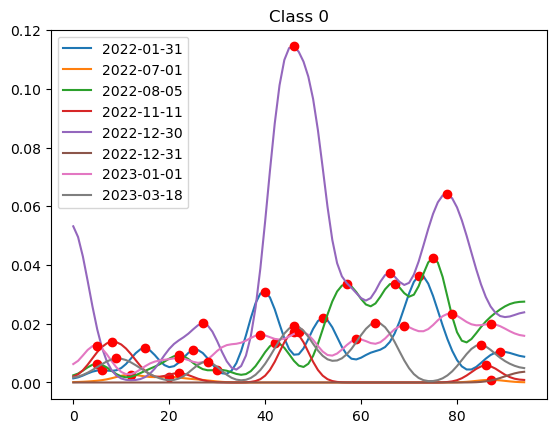

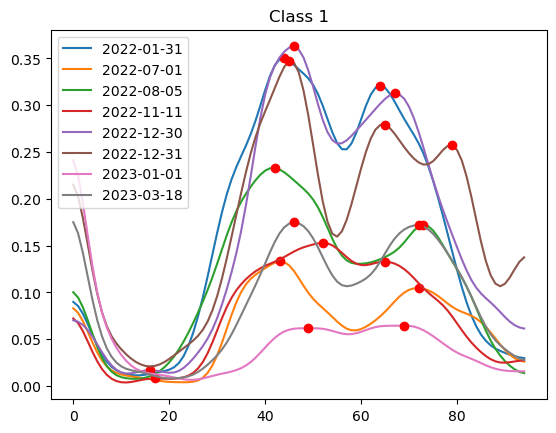

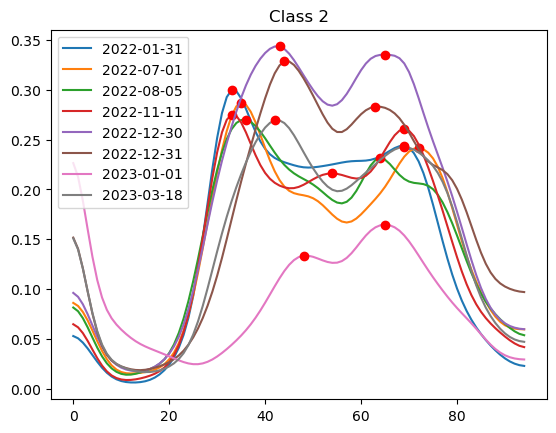

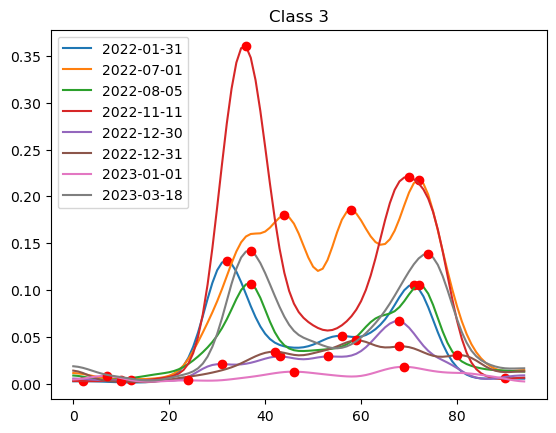

/tmp/ipykernel_61021/3093121898.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Days,rotation = 90)  # Set the ticks to correspond to the labels
/tmp/ipykernel_61021/3093121898.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Days,rotation = 90)  # Set the ticks to correspond to the labels
/tmp/ipykernel_61021/3093121898.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Days,rotation = 90)  # Set the ticks to correspond to the labels
/tmp/ipykernel_61021/3093121898.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(Days,rotation = 90)  # Set the ticks to correspond to

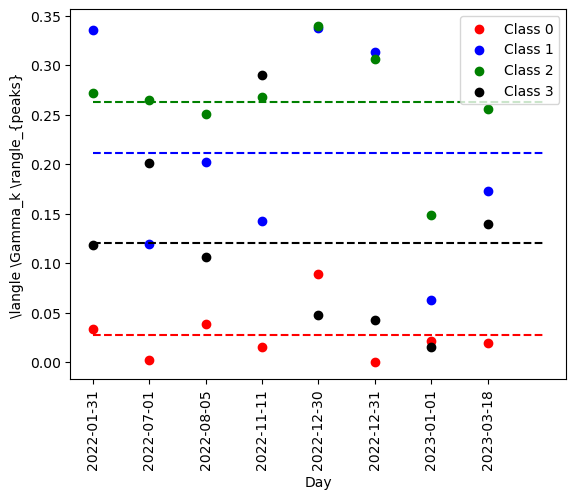

In [8]:
import polars as pl
import json
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import gaussian_filter1d

def sort_according_to_order(fixed_order, values_list, associated_list):
    # Pair the elements of the values_list with the associated_list
    paired_list = list(zip(values_list, associated_list))
    
    # Create a dictionary to map values to their positions in the fixed order
    order_dict = {value: index for index, value in enumerate(fixed_order)}
    
    # Sort the paired list according to the fixed order
    sorted_paired_list = sorted(paired_list, key=lambda x: order_dict[x[0]])
    
    # Unzip the sorted pairs back into separate lists
    sorted_values_list, sorted_associated_list = zip(*sorted_paired_list)
    
    return list(sorted_values_list), list(sorted_associated_list)


Classes = ["0","1","2","3"]
DfLinCoefClass = pl.read_csv(f"/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/LinearCoeff_{0}_NewClass.csv")
Days = DfLinCoefClass["Days"].unique().to_numpy()
Days = ["2022-01-31","2022-07-01","2022-08-05","2022-11-11","2022-12-30","2022-12-31","2023-01-01","2023-03-18"]
PlotDir = "/home/aamad/codice/city-pro/output/bologna_mdt_center/plots"


def PlotTrafficIForEachDay(Classes,Days,PlotDir):
    """AnalysisNetwork1Day.ipynb"""
    Class2AvgPeak = {Class:{"LinCoef":[], "AvPeak":[] }for Class in Classes}
    for Class in Classes:
        DfLinCoefClass = pl.read_csv(os.path.join(PlotDir,f"LinearCoeff_{Class}_NewClass.csv"))
        fig,ax = plt.subplots()
        DfLinCoefClassDay = DfLinCoefClass["LinearCoeff"].to_numpy()#.filter(pl.col("Days")==Day)
        DaysNew = DfLinCoefClass["Days"].unique().to_numpy()
        DaysNew, DfLinCoefClassDay = sort_according_to_order(Days, DaysNew, DfLinCoefClassDay)
        i = 0
        for Day in Days:
            with open(os.path.join(PlotDir,"TrafficIndexAllDays.json"), "r") as file:
                TrafficIndexAllDays = json.load(file)
            TrafficIndexDayClass = TrafficIndexAllDays[Day + "_" + Class]
            if Class == "0" or Class == 0:
                y = gaussian_filter1d(TrafficIndexDayClass, sigma=3)
            else:
                y = gaussian_filter1d(TrafficIndexDayClass, sigma=3)            
            peaks, _ = find_peaks(y)
            x = np.arange(len(y))
            ax.plot(x, y, label=Day)
            ax.plot(x[peaks], y[peaks], 'ro')
            plt.title(f"Class {Class}")
            plt.legend()
            if len(peaks) >= 2:
                mean = np.sort(y[peaks])
                Class2AvgPeak[Class]["AvPeak"].append(np.mean(mean[-2:]))
            else:
                Class2AvgPeak[Class]["AvPeak"].append(0)
            Class2AvgPeak[Class]["LinCoef"].append(DfLinCoefClassDay[i])
    #        print(Class,"Linear Coefficient: ",Class2AvgPeak[Class]["LinCoef"],"\nAverage Peak: ",Class2AvgPeak[Class]["AvPeak"])
            i += 1
        plt.show()
        plt.close()
    Colors = ["red","blue","green","black"]
    fig,ax = plt.subplots()
    for Class in Classes:
        ax.scatter(Days,Class2AvgPeak[Class]["AvPeak"],label="Class " +Class,color =Colors[int(Class)])
        ax.hlines(np.mean(Class2AvgPeak[Class]["AvPeak"]),0,len(Days),colors=Colors[int(Class)],linestyles='dashed')
        ax.set_xlabel("Day")
        ax.set_ylabel(r"\langle \Gamma_k \rangle_{peaks}")
        ax.legend()
        ax.set_xticklabels(Days,rotation = 90)  # Set the ticks to correspond to the labels
    plt.savefig(os.path.join(PlotDir,"AveragePeak.png"))
    plt.show()
    plt.close()

PlotTrafficIForEachDay(Classes,Days,PlotDir)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# Load data
df = pd.read_csv('/home/aamad/codice/city-pro/output/bologna_mdt_center/plots/TrafficIndexAllDays.csv')

# Average over days for each time
avg_df = df.groupby('Time')[['0', '1', '2', '3']].mean().reset_index()

# Prepare time axis for plotting
times = pd.to_datetime(avg_df['Time'], format='%H:%M:%S')
times = times.dt.hour + times.dt.minute / 60  # Convert to hours
x = np.arange(len(times))

plt.figure(figsize=(12, 7))
colors = ['blue', 'yellow', 'green', 'red']
labels = ['0', '1', '2', '3']

for i, col in enumerate(['0', '1', '2', '3']):
    y = avg_df[col].values
    y_smooth = gaussian_filter1d(y, sigma=3)
    # Find peaks
    peaks, _ = find_peaks(y_smooth)
    # Take top 2 peaks by height
    if len(peaks) > 0:
        peak_heights = y_smooth[peaks]
        top_peaks_idx = np.argsort(peak_heights)[-2:]  # take 2 largest
        top_peaks = peaks[top_peaks_idx]
    else:
        top_peaks = []

    # Plot
    plt.plot(times, y_smooth, label=f'class {col}', color=colors[i])
    plt.scatter(times[top_peaks], y_smooth[top_peaks], color=colors[i], marker='o', s=100, edgecolor='k', zorder=5, label='')

plt.xlabel('Time of Day')
plt.ylabel('Average Traffic Index')
plt.title('Gaussian Filtered Traffic Curves with Peaks Highlighted')
plt.legend()
plt.tight_layout()
plt.show()

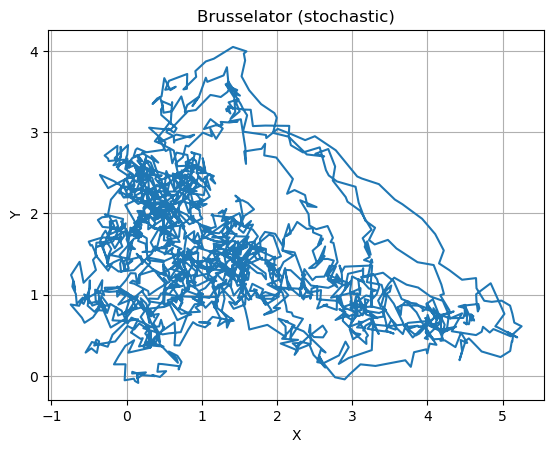

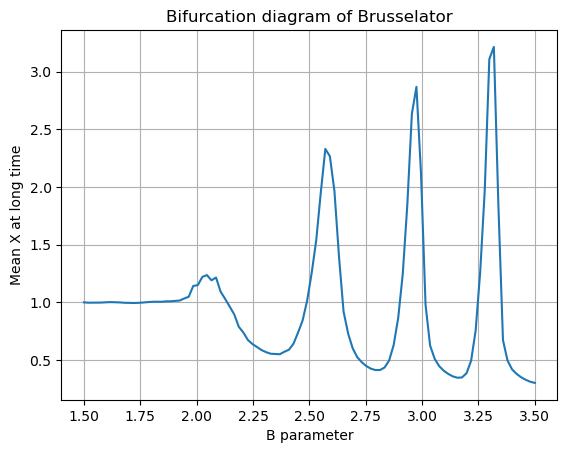

In [28]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

class ThermoReactiveSystem:
    def __init__(self, A=1.0, B=3.0, X0=[1.0, 1.0], t_span=(0, 20), dt=0.01, noise_strength=0.0):
        self.A = A
        self.B = B
        self.X0 = np.array(X0)
        self.t_span = t_span
        self.dt = dt
        self.noise_strength = noise_strength
        self.times = np.arange(t_span[0], t_span[1], dt)

    def brusselator_deterministic(self, t, Y):
        X, Y_ = Y
        dX = self.A - (self.B + 1) * X + X**2 * Y_
        dY = self.B * X - X**2 * Y_
        return [dX, dY]

    def integrate_deterministic(self):
        sol = solve_ivp(self.brusselator_deterministic, self.t_span, self.X0, t_eval=self.times)
        return sol.t, sol.y

    def integrate_stochastic(self):
        """Euler-Maruyama method"""
        X = np.zeros((2, len(self.times)))
        X[:, 0] = self.X0
        sqrt_dt = np.sqrt(self.dt)
        for i in range(1, len(self.times)):
            x, y = X[:, i-1]
            dx = self.A - (self.B + 1) * x + x**2 * y
            dy = self.B * x - x**2 * y
            dW = np.random.randn(2) * self.noise_strength
            X[0, i] = x + dx * self.dt + dW[0] * sqrt_dt
            X[1, i] = y + dy * self.dt + dW[1] * sqrt_dt
        return self.times, X

    def plot_trajectory(self, stochastic=True):
        t, X = self.integrate_stochastic() if stochastic else self.integrate_deterministic()
        plt.plot(X[0], X[1], label='Trajectory')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Brusselator ({"stochastic" if stochastic else "deterministic"})')
        plt.grid(True)
        plt.show()

def bifurcation_diagram(A=1.0, B_vals=np.linspace(1.5, 3.5, 100), t_max=100):
    final_X = []
    for B in B_vals:
        system = ThermoReactiveSystem(A=A, B=B, t_span=(0, t_max), dt=0.01)
        t, X = system.integrate_deterministic()
        x_vals = X[0, -100:]  # last values to detect oscillation
        final_X.append(np.mean(x_vals))  # could also store min/max for oscillations
    plt.plot(B_vals, final_X)
    plt.xlabel('B parameter')
    plt.ylabel('Mean X at long time')
    plt.title('Bifurcation diagram of Brusselator')
    plt.grid(True)
    plt.show()

# Stochastic trajectory
sys = ThermoReactiveSystem(B=2.5, noise_strength=1)
sys.plot_trajectory(stochastic=True)

# Bifurcation
bifurcation_diagram()
